In [7]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
from pathlib import Path

import glob
import random
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset  # Ensure Dataset is imported
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim

import cv2
from matplotlib.image import imread

import tensorflow as tf
#from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import glob
import PIL
import random

random.seed(100)

Num GPUs Available:  0


In [35]:
import glob

# Path to your local folder where images are stored, and specifying to look for PNG files recursively
breast_img_paths = glob.glob(r"D:/BC_ML/breast/**/*.png", recursive=True)

# Print the first 5 image paths
for img_path in breast_img_paths[:5]:
    print(img_path)


D:/BC_ML/breast\benign\adenosis\SOB_B_A-14-22549AB-100-001.png
D:/BC_ML/breast\benign\adenosis\SOB_B_A-14-22549AB-100-002.png
D:/BC_ML/breast\benign\adenosis\SOB_B_A-14-22549AB-100-003.png
D:/BC_ML/breast\benign\adenosis\SOB_B_A-14-22549AB-100-004.png
D:/BC_ML/breast\benign\adenosis\SOB_B_A-14-22549AB-100-005.png


In [37]:
# types of cancer
benign = []
malignant = []
# subtypes
A, F, PT, TA = [], [], [], [] # subtypes for benign
DC, LC, MC, PC = [], [], [], [] # subtypes for malignant

for img in breast_img_paths:
    img_name = Path(img).name
    if img_name[6] == 'A':
        A.append(img)
    elif img_name[6] == 'F':
        F.append(img)
    elif img_name[6] == 'P'and img_name[7] == 'T':
        PT.append(img)
    elif img_name[6] == 'T':
        TA.append(img)
    elif img_name[6] == 'D':
        DC.append(img)
    elif img_name[6] == 'L':
        LC.append(img)
    elif img_name[6] == 'M':
        MC.append(img)
    elif img_name[6] == 'P':
        PC.append(img)
    
    if img_name[4] == 'B':
        benign.append(img)
    else:
        malignant.append(img)
    

In [39]:
print("Total examples: ", len(breast_img_paths))
print("Number of benign examples", len(benign))
print("Number of malignant examples", len(malignant))

Total examples:  7909
Number of benign examples 2480
Number of malignant examples 5429


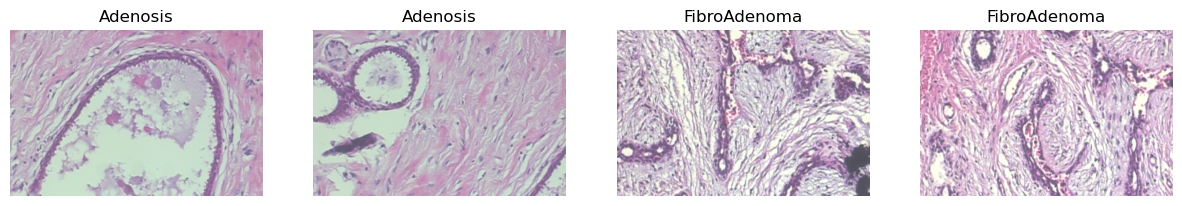

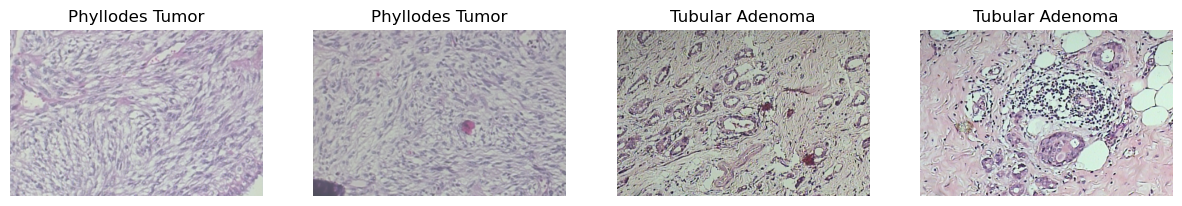

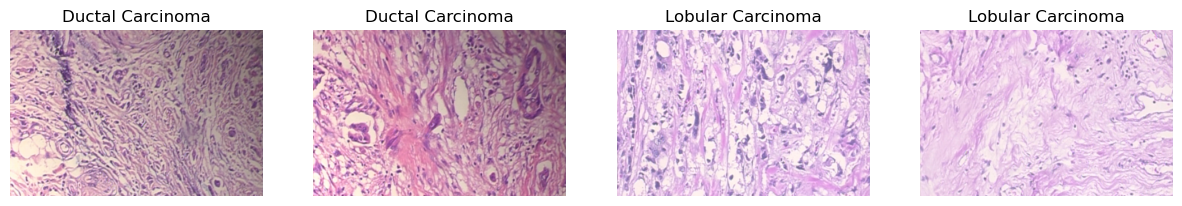

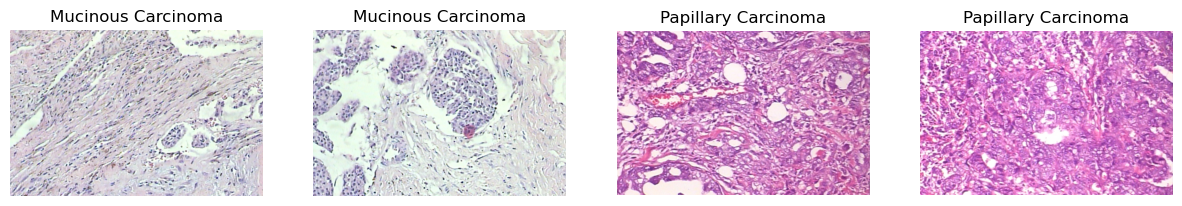

In [59]:
import matplotlib.image as mpimg

def display_images(label1, label2, list1, list2):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    for ax, img_path in zip(axes[:2], list1[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label1)  
        ax.axis('off')
    
    for ax, img_path in zip(axes[2:], list2[:2]):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(label2)
        ax.axis('off')
    plt.show()

# Display images from each list
display_images("Adenosis", "FibroAdenoma", A, F)
display_images("Phyllodes Tumor","Tubular Adenoma", PT, TA)
display_images("Ductal Carcinoma","Lobular Carcinoma", DC, LC)
display_images("Mucinous Carcinoma","Papillary Carcinoma", MC, PC)

In [43]:
def load_and_resize_images(img_list, label, size=(128, 128)):
    img_array = []
    for img in img_list:
        image = cv2.imread(img, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = tf.convert_to_tensor(image, dtype=tf.float32)
        image = image / 255.0
        if label != 4:
            augmented_images = augment_image(image)
            for aug_img in augmented_images:
                image_resized = tf.image.resize(aug_img, size)
                img_array.append([image_resized, label])
        else:
            image_resized = tf.image.resize(image, size)
            img_array.append([image_resized, label])

    return img_array

def augment_image(img):
    augmented_images = []

    augmented_images.append(img)

    for k in [1, 2]:
        rotated_img = tf.image.rot90(img, k=k)
        mirrored_rotated_img = tf.image.flip_left_right(rotated_img)
        augmented_images.append(mirrored_rotated_img)

    return augmented_images

A_imgs  = load_and_resize_images(A, 0)
F_imgs  = load_and_resize_images(F, 1)
PT_imgs  = load_and_resize_images(PT, 2)
TA_imgs = load_and_resize_images(TA, 3)
DC_imgs = load_and_resize_images(DC, 4)
LC_imgs = load_and_resize_images(LC, 5)
MC_imgs = load_and_resize_images(MC, 6)
PC_imgs = load_and_resize_images(PC, 7)

In [49]:
data_b = A_imgs + F_imgs + PT_imgs + TA_imgs 
data_m = DC_imgs + LC_imgs + MC_imgs + PC_imgs
print("Total number of benign examples:", len(data_b))
print("Total number of malignant examples:", len(data_m))

random.shuffle(data_b)
random.shuffle(data_m)

# Initial split to separate out the test set (20% of the data)
dataTrain_b, dataTest_b = train_test_split(data_b, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_b, dataVal_b = train_test_split(dataTrain_b, test_size=0.25, random_state=42)

# Initial split to separate out the test set (20% of the data)
dataTrain_m, dataTest_m = train_test_split(data_m, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (75% train, 25% val of 80% train-val data)
dataTrain_m, dataVal_m = train_test_split(dataTrain_m, test_size=0.25, random_state=42)

dataTrain_b_modified = [(image, 0) for image, label in dataTrain_b]
dataTrain_m_modified = [(image, 1) for image, label in dataTrain_m]

dataTrain = dataTrain_b_modified + dataTrain_m_modified
random.shuffle(dataTrain)

dataVal_b_modified = [(image, 0) for image, label in dataVal_b]
dataVal_m_modified = [(image, 1) for image, label in dataVal_m]

dataVal = dataVal_b_modified + dataVal_m_modified
random.shuffle(dataVal)

dataTest_b_modified = [(image, 0) for image, label in dataTest_b]
dataTest_m_modified = [(image, 1) for image, label in dataTest_m]

dataTest = dataTest_b_modified + dataTest_m_modified

print("Total number of examples:", len(dataTrain) + len(dataVal) + len(dataTest))

Total number of benign examples: 7440
Total number of malignant examples: 9385
Total number of examples: 16825


In [51]:
def create_tf_dataset(img_list, batch_size=64):
    images, labels = zip(*img_list)
    images = np.array(images)  # Convert images to numpy array
    labels = np.array(labels)
    
    # One-hot encode labels
    labels = tf.keras.utils.to_categorical(labels, num_classes=2)
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

with tf.device('/GPU:0'):
    train_dataset = create_tf_dataset(dataTrain)
    val_dataset = create_tf_dataset(dataVal)
    test_dataset = create_tf_dataset(dataTest)

In [53]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [56]:
# Base Model
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
# base_model.trainable = False
# Extract intermediate layers
layer_names = ['conv3_block12_concat', 'conv4_block24_concat', 'conv5_block16_concat']
intermediate_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create a new model that outputs intermediate layers
intermediate_model = Model(inputs=base_model.input, outputs=intermediate_outputs)

# Define the branches for each intermediate output
branch_outputs = []
for output in intermediate_outputs:
    x = GlobalAveragePooling2D()(output)
    x = Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x)
    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    branch_outputs.append(x)
# Concatenate the branch outputs for score-level fusion
fusion = tf.keras.layers.Concatenate()(branch_outputs)

# Final dense layers
x = Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(fusion)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
final_output = Dense(2, activation='softmax')(x)

# Combine everything into a model
binary_model = Model(inputs=base_model.input, outputs=final_output)

optimizer = Adam(learning_rate=0.0001)

binary_model.compile(optimizer=optimizer,
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step



In [58]:
import time

start_time = time.time()

history = binary_model.fit(train_dataset,
                           validation_data=val_dataset,
                           epochs=50,
                           callbacks=[early_stopping, reduce_lr])

end_time = time.time()

total_time = end_time - start_time
print(f"Total time taken to train the model: {total_time:.2f} seconds")

Epoch 1/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 1323s 8s/step - accuracy: 0.7540 - loss: 0.9685 - val_accuracy: 0.7964 - val_loss: 1.0007 - learning_rate: 1.0000e-04
Epoch 2/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 950s 6s/step - accuracy: 0.9185 - loss: 0.5689 - val_accuracy: 0.9028 - val_loss: 0.7595 - learning_rate: 1.0000e-04
Epoch 3/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 822s 5s/step - accuracy: 0.9478 - loss: 0.4771 - val_accuracy: 0.9525 - val_loss: 0.4984 - learning_rate: 1.0000e-04
Epoch 4/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 815s 5s/step - accuracy: 0.9730 - loss: 0.4058 - val_accuracy: 0.9525 - val_loss: 0.4525 - learning_rate: 1.0000e-04
Epoch 5/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 806s 5s/step - accuracy: 0.9778 - loss: 0.3876 - val_accuracy: 0.9646 - val_loss: 0.4148 - learning_rate: 1.0000e-04
Epoch 6/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 858s 5s/step - accuracy: 0.9863 - loss: 0.3447 - val_accuracy: 0.9646 - val_loss: 0.4203 - learning_rate: 1.0000e-04
Epoch 7/50
158/158 ━━━━━━━━━━━━━━━━━━━━ 841s 5s/step - ac

In [62]:
test_loss, test_acc = binary_model.evaluate(test_dataset)
print(f"Test accuracy (binary classification): {test_acc}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9871 - loss: 0.1294
Test accuracy (binary classification): 0.9851411581039429
